<a href="https://colab.research.google.com/github/sofials2002/SOFIA/blob/master/RDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Discontinuity Design

This notebook is based on a lab from Chapter 17 of the book [Applied Causal Inference Powered by ML and AI](https://causalml-book.org). It examines how the Progresa antipoverty program affected household consumption patterns in Mexico during the early 2000s.

The program targeted families living in extreme poverty, offering financial incentives to encourage participation in activities aimed at improving health, nutrition, and children’s education.

Eligibility was determined by a pre-intervention household poverty index, where families above a certain threshold qualified for the program (the treatment group), while those below it were excluded (the control group). Since all families above the threshold participated, the analysis follows a standard (sharp) regression discontinuity design.

Data by [Calonico et al. (2014)](https://rdpackages.github.io/references/Calonico-Cattaneo-Titiunik_2014_ECMA--Supplemental.pdf) and analysis by [Noack et al. (2023)](https://arxiv.org/pdf/2107.07942.pdf).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

In [2]:
!pip install rdd

  Preparing metadata (setup.py) ... done
  Created wheel for rdd: filename=rdd-0.0.3-py3-none-any.whl size=4701 sha256=fb5d71806ba7997bd7011783ab6af3bbfbe01a8a2a177c367207240448202e0c
  Stored in directory: /root/.cache/pip/wheels/53/bb/d2/0f022533528e6302bfd539ede3617bf64005b1a329540136b7
Successfully built rdd


## Data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/progresa.csv",
                 index_col=0)
df = df.dropna()
df = df.rename(columns={'index': 'pov_index'})
df.tail()

,hhpiso,hhrooms,hhwater,hhwaterin,hhbano,hhownhouse,hhsize,hhelect,clus,headmale,...,pov_index,conspcfood_t0,conspcfood_t1,conspcfood_t2,conspcnonfood_t0,conspcnonfood_t1,conspcnonfood_t2,conspc_t0,conspc_t1,conspc_t2
2801,1.0,3.0,0.0,0.0,1.0,1.0,6,1,177,1,...,0.1485,258.226654,232.190002,303.880005,65.724442,74.639999,79.166672,323.951111,306.830017,383.046692
2805,1.0,1.0,0.0,0.0,1.0,1.0,6,1,177,1,...,1.0550,137.673340,282.480011,264.137146,24.713333,110.535553,65.897141,162.386673,393.015564,330.034302
2806,1.0,1.0,0.0,0.0,0.0,1.0,4,1,177,1,...,0.6280,108.070000,321.000000,543.559998,21.850000,132.290009,119.229996,129.919998,453.290009,662.789978
2808,1.0,1.0,0.0,0.0,1.0,1.0,5,1,177,1,...,0.9600,145.520004,221.703995,301.312012,13.856000,106.309326,167.085327,159.376007,328.013306,468.397339
2809,1.0,2.0,0.0,0.0,1.0,1.0,6,1,177,1,...,-0.1890,207.580002,282.480011,197.735992,66.213333,125.290672,89.391998,273.793335,407.770691,287.127991


## Estimation without Covariates

First, we will perform a very simple RD estimation with a weighted linear regression. We use a triangular kernel, which assigns weights to observations based on their distance from the cutoff point. The weights decrease linearly as the distance from the cutoff point increases.

In [4]:
def triangular_kernel(index, h):
    weights = 1 - np.abs(index) / h
    weights[weights < 0] = 0
    return weights

    #Triangular kernel linearly decreases the weights. It's basically doing a weighted least squares.

The parameter `h` is the bandwidth that controls the range of observations that receive non-zero weights. We use the `IKbandwidth` function from the `rdd` package that implements the *Imbens-Kalyanaraman* method. Another standard approach would be to use the standard deviation of `index`.

In [5]:
from rdd.rdd import optimal_bandwidth

h = optimal_bandwidth(X=df['pov_index'], Y=df['conspcfood_t2'], cut=0)
print('Optimal bandwidth:', round(h, 2)) #this is the optimal bandwidth.

Optimal bandwidth: 0.71


We use the triangular kernel function to calculate weights for each observation. After that, we can fit two separate linear regressions for both treatment and control groups.

In [6]:
from sklearn.linear_model import LinearRegression, LassoCV

weights = triangular_kernel(df['pov_index'], h)
model_treated, model_control = LinearRegression(), LinearRegression()
model_treated.fit(y=df.loc[df['pov_index'] > 0, 'conspcfood_t2'].values.reshape(-1, 1),
                  X=df.loc[df['pov_index'] > 0, 'pov_index'].values.reshape(-1, 1),
                  sample_weight=weights[df['pov_index'] > 0])
model_control.fit(y=df.loc[df['pov_index'] < 0, 'conspcfood_t2'].values.reshape(-1, 1),
                  X=df.loc[df['pov_index'] < 0, 'pov_index'].values.reshape(-1, 1),
                  sample_weight=weights[df['pov_index'] < 0])

LinearRegression()

In [8]:
cutoff = 0
treatment_effect = model_treated.predict(np.array([cutoff]).reshape(-1, 1))
treatment_effect -= model_control.predict(np.array([cutoff]).reshape(-1, 1))
print('Treatment effect:', round(treatment_effect[0,0], 2))

#participating in the program increases food consumption by 53. (Treatment effect).

Treatment effect: 53.2


We estimate that the participation in the program increased food consumption by $53.1$ units in the second year following the intervention.

The following plot visualizes the two weighted regressions at the cut-off for the outcome variable. We can clearly see the "jump" at the cut-off, which is our LATE.

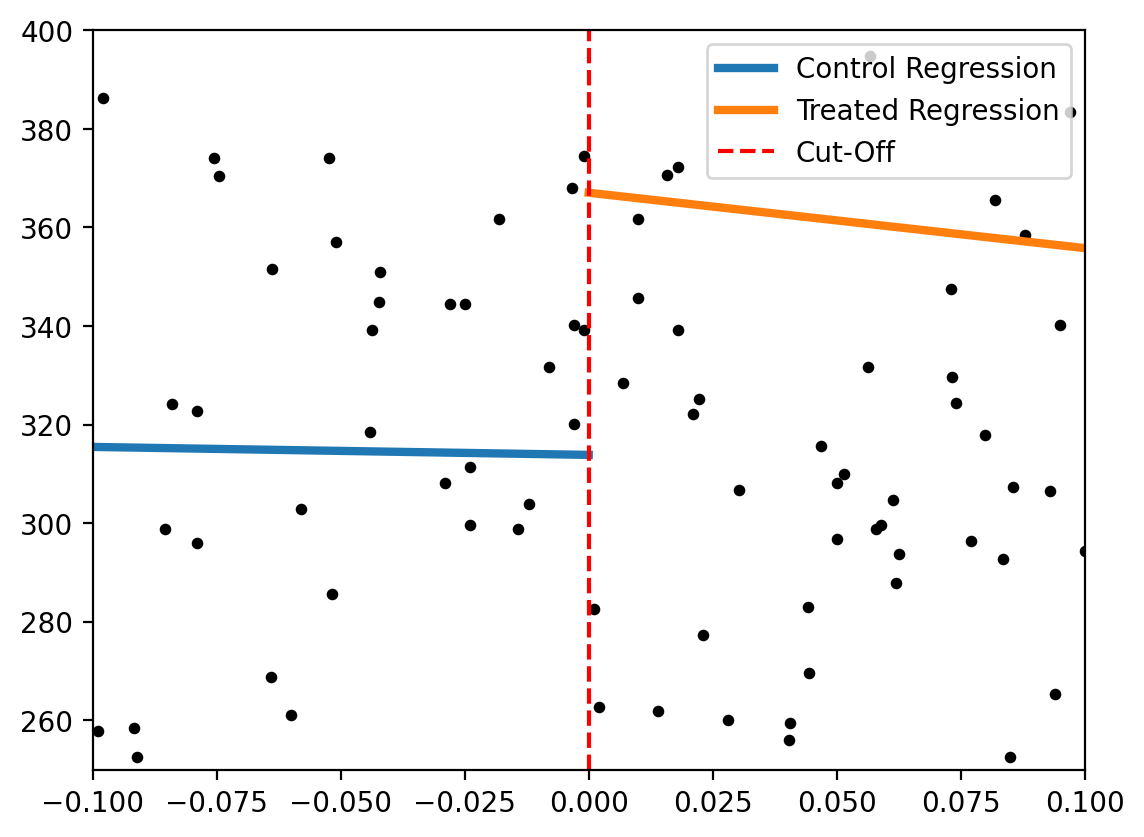

In [9]:
plt.scatter(df.pov_index, df.conspcfood_t1, s=10, color='black')  # s controls the size
neg_xval = np.linspace(-0.1, 0, 100)
neg_line = model_control.predict(neg_xval.reshape(-1, 1))
pos_xval = np.linspace(0, 0.1, 100)
pos_line = model_treated.predict(pos_xval.reshape(-1, 1))
plt.plot(neg_xval, neg_line, linewidth=3, label="Control Regression")
plt.plot(pos_xval, pos_line, linewidth=3, label="Treated Regression")
plt.axvline(x=0, color='red', linestyle='--', label="Cut-Off")
plt.legend()
plt.xlim(-0.1, 0.1)
plt.ylim(250, 400)
plt.show()

In [10]:
# What happens when you use a bigger or smaller bandwidth? (SMALLER). What happens to the treatment effect?
h=0.2

weights = triangular_kernel(df['pov_index'], h)
model_treated, model_control = LinearRegression(), LinearRegression()
model_treated.fit(y=df.loc[df['pov_index'] > 0, 'conspcfood_t2'].values.reshape(-1, 1),
                  X=df.loc[df['pov_index'] > 0, 'pov_index'].values.reshape(-1, 1),
                  sample_weight=weights[df['pov_index'] > 0])
model_control.fit(y=df.loc[df['pov_index'] < 0, 'conspcfood_t2'].values.reshape(-1, 1),
                  X=df.loc[df['pov_index'] < 0, 'pov_index'].values.reshape(-1, 1),
                  sample_weight=weights[df['pov_index'] < 0])




LinearRegression()

In [11]:
cutoff = 0
treatment_effect = model_treated.predict(np.array([cutoff]).reshape(-1, 1))
treatment_effect -= model_control.predict(np.array([cutoff]).reshape(-1, 1))
print('Treatment effect:', round(treatment_effect[0,0], 2))

Treatment effect: 52.87


In [12]:
!pip install rdrobust

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


We can repeat the estimation using the `rdd` package that gives us confidence bands.

In [13]:
from rdrobust import rdrobust

rdd_result = rdrobust(x=df['pov_index'], y=df['conspcfood_t2'], rho=1, masspoints="off")
print('The treatment effect is {:.1f} with a standard error of {:.1f}'.format(rdd_result.coef.iloc[0].values[0], rdd_result.se.iloc[2].values[0]))

The treatment effect is 55.0 with a standard error of 48.1


In [14]:
rdd_result

Call: rdrobust
Number of Observations:                  1944
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           549       1395
Number of Unique Obs.            549       1395
Number of Effective Obs.         303        391
Bandwidth Estimation           0.442      0.442
Bandwidth Bias                 0.442      0.442
rho (h/b)                        1.0        1.0

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      54.957   38.396    1.431   1.523e-01 [-20.297, 130.211]
Robust                 -        -    1.135   2.563e-01 [-39.691, 148.937]


In [15]:
# What is the effect for conspcfood_t1?
rdresult = rdrobust(x=df['pov_index'], y=df['conspcfood_t1'], rho=1, masspoints="off")
print(rdresult) #meaning the coefficient is not significant.

Call: rdrobust
Number of Observations:                  1944
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           549       1395
Number of Unique Obs.            549       1395
Number of Effective Obs.         268        328
Bandwidth Estimation           0.372      0.372
Bandwidth Bias                 0.372      0.372
rho (h/b)                        1.0        1.0

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional     -22.162   20.197   -1.097   2.725e-01  [-61.747, 17.423]
Robust                 -        -    0.188   8.508e-01  [-48.649, 58.979]



## Estimation with Covariates

The standard approach is simply to take up the regressors in the weighted least squares regression.

In [16]:
model_treated, model_control = LinearRegression(), LinearRegression()
model_treated.fit(y=df.loc[df['pov_index'] > 0, 'conspcfood_t2'].values.reshape(-1, 1),
                  X=df.loc[df['pov_index'] > 0, ['pov_index', 'hhownhouse', 'headage', 'heademp', 'headeduc']],
                  sample_weight=weights[df['pov_index'] > 0])
model_control.fit(y=df.loc[df['pov_index'] < 0, 'conspcfood_t2'].values.reshape(-1, 1),
                  X=df.loc[df['pov_index'] < 0, ['pov_index', 'hhownhouse', 'headage', 'heademp', 'headeduc']],
                  sample_weight=weights[df['pov_index'] < 0])

LinearRegression()

In [17]:
pred_t = model_treated.predict(pd.DataFrame({'pov_index': cutoff,
                                             'hhownhouse': np.average(df.loc[df.pov_index > 0, 'hhownhouse'],
                                                                      weights=weights[df.pov_index > 0]),
                                             'headage': np.average(df.loc[df.pov_index > 0, 'headage'],
                                                                   weights=weights[df.pov_index > 0]),
                                             'heademp': np.average(df.loc[df.pov_index > 0, 'heademp'],
                                                                   weights=weights[df.pov_index > 0]),
                                             'headeduc': np.average(df.loc[df.pov_index > 0, 'headeduc'],
                                                                    weights=weights[df.pov_index > 0])},
                                            index=[0]))
pred_c = model_control.predict(pd.DataFrame({'pov_index': cutoff,
                                             'hhownhouse': np.average(df.loc[df.pov_index < 0, 'hhownhouse'],
                                                                      weights=weights[df.pov_index < 0]),
                                             'headage': np.average(df.loc[df.pov_index < 0, 'headage'],
                                                                   weights=weights[df.pov_index < 0]),
                                             'heademp': np.average(df.loc[df.pov_index < 0, 'heademp'],
                                                                   weights=weights[df.pov_index < 0]),
                                             'headeduc': np.average(df.loc[df.pov_index < 0, 'headeduc'],
                                                                    weights=weights[df.pov_index < 0])},
                                            index=[0]))
treatment_effect = pred_t - pred_c
print('Treatment effect:', round(treatment_effect[0,0], 2))

Treatment effect: 49.83


Including these selected covariates does not have a significant impact on the LATE estimation.

We can also use `rdd`.


In [18]:
rdd_result = rdrobust(x=df.pov_index, y=df['conspcfood_t2'], rho=1, masspoints="off",
                      covs=df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 18, 21]])
print('The treatment effect is {:.1f} with a standard error of {:.1f}'.format(rdd_result.coef.iloc[0].values[0], rdd_result.se.iloc[2].values[0]))

The treatment effect is 57.3 with a standard error of 44.4


In [20]:
rdd_result #here its using a mse method to calculate the bandwidth.
#We can try and change some of the covariates, the outcome,
#the kernel or the bandwith and see what happens .

Call: rdrobust
Number of Observations:                  1944
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           549       1395
Number of Unique Obs.            549       1395
Number of Effective Obs.         299        384
Bandwidth Estimation           0.434      0.434
Bandwidth Bias                 0.434      0.434
rho (h/b)                        1.0        1.0

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      57.287   35.704    1.605   1.086e-01 [-12.691, 127.265]
Robust                 -        -    1.074   2.828e-01 [-39.312, 134.615]


Overall, the adjustment by only a few covariates has not changed the estimated coefficient much from the result without covariates. However, including covariates does reduce the standard deviation of the estimation.

In [ ]:
# What are the efficiency gains with conspcfood_t1?




## Estimation using ML

Including many covariates in RDD estimation can be beneficial for multiple reasons:

1. **Efficiency and power improvements**: As in randomized control trials, using covariates can increase efficiency and improve power.

2. **Auxiliary information**: In RDD the score determines the treatment assignment and measurement errors in the running variable can distort the results. Additional covariates can be exploited to overcome these issues or to deal with missing data problems.

3. **Treatment effect heterogeneity**: Covariates can be used to define subgroups in which the treatment effects differ.

4. **Other parameters of interest and extrapolation**: As the identified treatment effect in RDD is local at the cutoff, additional covariates might help for extrapolation of the treatment effects or identify other causal parameters.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
import patsy

In [22]:
# Running Variable and Outcome
investigated_outcome = 'conspcfood_t2'
df_ml = df.rename(columns={'pov_index': 'X', investigated_outcome: 'Y'})

# Baseline covariates including consumption
b_covs = df_ml.columns[[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 18, 21]]

# Fixed effects for localities
i_fe = pd.get_dummies(df_ml['clus'], drop_first=True)

# Flexible covariates including localities indicators
f_covs = patsy.dmatrix('~ (' + ' + '.join(b_covs) + ')**2', data=df_ml, return_type='dataframe')

# Dropping the intercept column that is automatically added by patsy
f_covs = f_covs.iloc[:, 1:]

Z_lasso = pd.concat([i_fe, f_covs], axis=1)

We will use the package `rdrobust` for the RD estimation. Before starting the DML procedure, we have to estimate a bandwidth to restrict the samples in the first stage estimation.

In [23]:
h_fs = rdrobust(y=df_ml.Y, x=df_ml.X, masspoints="off").bws.values[1, 0]

In [24]:
h_fs

0.5850575928364151

The next chunk sets up the crossfitting and estimates the function $\eta(Z)$, which we will use to adjust $Y$ for the second stage. We use Random Forest, a Boosting implementation, Linear Regression and Lasso with both a baseline and flexible covariate structure.

In [ ]:
def first_stage(df_ml, b_covs, h_fs, Z_lasso, Kf=5, random_seed=123):
    '''
    df_ml: dataframe
    b_covs: which columns of the data frame will be used as baseline covariates
    h_fs: bandwidth around discontinuity for training points
    Z_lasso: dataframe with extra baseline covariates in high-dimensional specification
    '''
    # Set up the cross-fitting
    n = df_ml.shape[0]
    # Matrix to store eta predictions
    eta_fit = np.empty((n, 3))

    # Create vector of observations to be considered in the first stage model
    weights = np.abs(df_ml.X) < h_fs

    for train, test in KFold(shuffle=True, n_splits=Kf, random_state=random_seed).split(df_ml.X, df_ml.Y):

        df_train = df_ml.iloc[train]
        treated_train = (df_train.X > 0) & (weights.iloc[train] > 0)
        control_train = (df_train.X < 0) & (weights.iloc[train] > 0)
        data_treated = df_train[treated_train]
        data_control = df_train[control_train]

        data_fold = df_ml.iloc[test]

        rf1 = RandomForestRegressor(max_features=4, n_estimators=1000, random_state=random_seed)
        rf1.fit(data_treated[b_covs], data_treated.Y)
        rf0 = RandomForestRegressor(max_features=4, n_estimators=1000, random_state=random_seed)
        rf0.fit(data_control[b_covs], data_control.Y)
        eta_fit[test, 0] = (rf1.predict(data_fold[b_covs]) + rf0.predict(data_fold[b_covs])) / 2

        lgbm1 = LGBMRegressor(verbosity=-1, random_state=random_seed)
        lgbm1.fit(data_treated[b_covs], data_treated.Y)
        lgbm0 = LGBMRegressor(verbosity=-1, random_state=random_seed)
        lgbm0.fit(data_control[b_covs], data_control.Y)
        eta_fit[test, 1] = (lgbm1.predict(data_fold[b_covs]) + lgbm0.predict(data_fold[b_covs])) / 2

        lm1 = LinearRegression()
        lm1.fit(data_treated[b_covs], data_treated.Y)
        lm0 = LinearRegression()
        lm0.fit(y=data_control.Y, X=data_control[b_covs])
        eta_fit[test, 2] = (lm1.predict(data_fold[b_covs]) + lm0.predict(data_fold[b_covs])) / 2

        las_base1 = LassoCV(random_state=random_seed)
        las_base1.fit(data_treated[b_covs], data_treated.Y)
        las_base0 = LassoCV(random_state=random_seed)
        las_base0.fit(data_control[b_covs], data_control.Y)
        eta_fit[test, 3] = (las_base1.predict(data_fold[b_covs]) + las_base0.predict(data_fold[b_covs])) / 2

        X_flex_treated = pd.concat([Z_lasso.loc[data_treated.index], data_treated[b_covs]], axis=1)
        X_flex_control = pd.concat([Z_lasso.loc[data_control.index], data_control[b_covs]], axis=1)
        X_flex_fold = pd.concat([Z_lasso.loc[data_fold.index], data_fold[b_covs]], axis=1)
        X_flex_treated.columns = X_flex_treated.columns.astype(str)
        X_flex_control.columns = X_flex_control.columns.astype(str)
        X_flex_fold.columns = X_flex_fold.columns.astype(str)
        las_flex1 = LassoCV(random_state=random_seed)
        las_flex1.fit(X_flex_treated, data_treated.Y)
        las_flex0 = LassoCV(random_state=random_seed)
        las_flex0.fit(X_flex_control, data_control.Y)
        eta_fit[test, 4] = (las_flex1.predict(X_flex_fold) + las_flex0.predict(X_flex_fold)) / 2

    return eta_fit

In [ ]:
eta_fit = first_stage(df_ml, b_covs, h_fs, Z_lasso, random_seed=0)

With the estimated $\hat{\eta}(Z)$ we can correct for confounding in $Y$ and now run the RD estimation as second stage again.

In [ ]:
methods = ["Random Forest", "Gradient Boosting", "Linear Regression",
           "Lasso Baseline", "Lasso Flexible"]


def second_stage(df_ml, eta_fit, methods):
    adj_results = []
    for i in range(len(methods)):
        M_Y = df_ml.Y - eta_fit[:, i]
        rd_call = rdrobust(y=M_Y, x=df_ml.X, masspoints="off")
        adj_results.append([rd_call.coef.iloc[0].values[0],
                            rd_call.se.iloc[2].values[0]])
    return adj_results

In [ ]:
adj_frame = pd.DataFrame(second_stage(df_ml, eta_fit, methods),
                         columns=["LATE", "s.e."],
                         index=methods)
adj_frame

,LATE,s.e.
Random Forest,62.813911,44.584670
Gradient Boosting,68.099441,44.595872
Linear Regression,60.530912,44.460227
Lasso Baseline,55.533087,45.083626
Lasso Flexible,53.960384,45.608324


Finally, we create a small simulation study with only $R=20$ repetitions to show the variance reducing effect of the inclusion of ML-based estimators for the covariates. The next block runs up to ten minutes.

In [ ]:
from joblib import Parallel, delayed


def exp(i):
    eta_fit = first_stage(df_ml, b_covs, h_fs, Z_lasso, random_seed=i)
    return np.array(second_stage(df_ml, eta_fit, methods))


results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(i) for i in range(20))

estimates = [results[i][:, 0] for i in range(20)]
std_err = [results[i][:, 1] for i in range(20)]

We aggregate the median of the estimates, the mean of the standard errors and also calculate the mean reduction of standard error compared to the "no covariates" estimation. We see, that including covariates can reduce the standard error of estimation around 15-20%.

In [ ]:
med_est = np.median(np.array(estimates), axis=0)
mean_se = np.array(std_err).mean(axis=0)
adj_frame = pd.DataFrame(np.c_[med_est, mean_se], index=methods, columns=["LATE", "s.e."])
adj_frame["% reduction"] = (adj_frame["s.e."] - res_dataframe.loc["Food T_1", "s.e."]) * 100
adj_frame["% reduction"] /= res_dataframe.loc["Food T_1", "s.e."]
adj_frame.loc["Linear Adjusted (no cross-fit)"] = res_dataframe_adj.loc["Food T_1"]
adj_frame